In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from utils.notebook_config import *
import random
from utils.simulation import *

In [33]:
# #This case: Large pool of TFs A,B,C, so we assume that p_a ,p_B and p_C are constant and both rna strings have the same probablilities. Also the unbound probabilities are the same as p_a, etc.


# def simulation_dustin(probs: list, timesteps: int, shots: int):
#     avg1, avg2, std1, std2 = [],[],[],[]
#     total1, total2 = np.array([0 for i in range(timesteps)]), np.array([0 for i in range(timesteps)])

#     corr = np.array([[0,0],[0,0]])

#     for z in range(shots):
#         rna1 = [0,0,0]
#         rna2 = [0,0,0]
#         p_a, p_b, p_c, p_m1, p_m2, p_m3 = probs[0], probs[1], probs[2], probs[3], probs[4], probs[5]

#         protein1, protein2 = [],[]                #amount of protein produced in every timestep

#         for i in range(timesteps):

#             prots1 = 0
#             for i in rna1:
#                 if i != 0 and i != "M":
#                     prots1 += 1
#             protein1.append(prots1)
#             prots2 = 0
#             for i in rna2:
#                 if i != 0 and i != "M":
#                     prots2 += 1
#             protein2.append(prots2)

#             order = np.random.permutation(6)       #random order
#             for k in order:
#                 if k-3 < 0:
#                     #########################        Check if empty --> Either A docks or M, depending on p_a/p_m
#                     if k == 0 and rna1[k] == 0:
#                         r1, r2 = random.random(), random.random()
#                         if r1 <= p_a and r2 > p_m1:
#                             rna1[k] = "A"
#                             continue
#                         elif r1 > p_a and r2 <= p_m1:
#                             rna1[k] = "M"
#                             continue
#                     if k == 1 and rna1[k] == 0:
#                         r1, r2 = random.random(), random.random()
#                         if r1 <= p_a and r2 > p_m2:
#                             rna1[k] = "B"
#                             continue
#                         elif r1 > p_a and r2 <= p_m2:
#                             rna1[k] = "M"
#                             continue
#                     if k == 2 and rna1[k] == 0:
#                         r1, r2 = random.random(), random.random()
#                         if r1 <= p_a and r2 > p_m3:
#                             rna1[k] = "C"
#                             continue
#                         elif r1 > p_a and r2 <= p_m3:
#                             rna1[k] = "M"
#                             continue
#                     ###########################            Check if already A/B/C are docked --> undock depending p_a etc.
#                     if k == 0 and rna1[k] == "A":
#                         if random.random() <= p_a:
#                             rna1[k] = 0
#                             continue
#                     if k == 1 and rna1[k] == "B":
#                         if random.random() <= p_b:
#                             rna1[k] = 0
#                             continue
#                     if k == 2 and rna1[k] == "C":
#                         if random.random() <= p_c:
#                             rna1[k] = 0
#                             continue
#                     #############################            Check for methylation --> un-methylize depending on p_m
#                     if k == 0 and rna1[k] == "M":
#                         if random.random() <= p_m1:
#                             rna1[k] = 0
#                             continue
#                     if k == 1 and rna1[k] == "M":
#                         if random.random() <= p_m2:
#                             rna1[k] = 0
#                             continue
#                     if k == 2 and rna1[k] == "M":
#                         if random.random() <= p_m3:
#                             rna1[k] = 0
#                             continue
#                 ############################################################### Do the same for the second rna!
#                 else:
#                     k = k-3
#                     if k == 0 and rna2[k] == 0:
#                         r1, r2 = random.random(), random.random()
#                         if r1 <= p_a and r2 > p_m1:
#                             rna2[k] = "A"
#                             continue
#                         elif r1 > p_a and r2 <= p_m1:
#                             rna2[k] = "M"
#                             continue
#                     if k == 1 and rna2[k] == 0:
#                         r1, r2 = random.random(), random.random()
#                         if r1 <= p_a and r2 > p_m2:
#                             rna2[k] = "B"
#                             continue
#                         elif r1 > p_a and r2 <= p_m2:
#                             rna2[k] = "M"
#                             continue
#                     if k == 2 and rna2[k] == 0:
#                         r1, r2 = random.random(), random.random()
#                         if r1 <= p_a and r2 > p_m3:
#                             rna2[k] = "C"
#                             continue
#                         elif r1 > p_a and r2 <= p_m3:
#                             rna2[k] = "M"
#                             continue
#                     ###########################            Check if already A/B/C are docked --> undock depending p_a etc.
#                     if k == 0 and rna2[k] == "A":
#                         if random.random() <= p_a:
#                             rna2[k] = 0
#                             continue
#                     if k == 1 and rna2[k] == "B":
#                         if random.random() <= p_b:
#                             rna2[k] = 0
#                             continue
#                     if k == 2 and rna2[k] == "C":
#                         if random.random() <= p_c:
#                             rna2[k] = 0
#                             continue
#                     #############################            Check for methylation --> un-methylize depending on p_m
#                     if k == 0 and rna2[k] == "M":
#                         if random.random() <= p_m1:
#                             rna2[k] = 0
#                             continue
#                     if k == 1 and rna2[k] == "M":
#                         if random.random() <= p_m2:
#                             rna2[k] = 0
#                             continue
#                     if k == 2 and rna2[k] == "M":
#                         if random.random() <= p_m3:
#                             rna2[k] = 0
#                             continue
#         total1 = np.vstack((total1, protein1))
#         total2 = np.vstack((total2, protein2))
#         corr = corr + np.corrcoef(protein1, protein2)
#     total1 = np.delete(total1, (0), axis=0)
#     total2 = np.delete(total2, (0), axis=0)
#     for i in total1.T:
#         avg1.append(np.mean(i))
#         std1.append(np.std(i))
#     for i in total2.T:
#         avg2.append(np.mean(i))
#         std2.append(np.std(i))
#     corr = corr/shots
#     time = [i for i in range(timesteps)]

#     return time, avg1, std1, avg2, std2, corr


In [34]:
# probabilities  = np.random.rand(6)/5

# time, avg1, std1, avg2, std2, corr = simulation_dustin(probs=probabilities, timesteps=300, shots = 100)         

In [35]:
# probabilities = [0.08, 0.08, 0.08, 0.02, 0.02, 0.02]

# time, avg1, std1, avg2, std2, corr = simulation_dustin(probs=probabilities, timesteps=300, shots = 1000)   

# plt.plot(time, avg1, label="1. RNA")
# plt.plot(time, avg2, label="2. RNA")
# plt.xlabel("Timestep")
# plt.title("Avg. producationrate of protein")
# plt.legend()
# plt.show()

# print(corr)

In [36]:
#Work here with the defined classes in simulation2.py

n = 1

p1, m_on, m_off = 0.01, 0.1, 0.1

# gene1 = gene(3, boxes, p1, p2)
# gene2 = gene(3, boxes, p1, p2)

steps = 2000

shots = 5000

simu = simulation(timesteps=steps)

avg1, std1, avg2, std2, corr = simu.average(n, p1, m_on, m_off, shots, m_switch=False)
avg1m, std1m, avg2m, std2m, corrm = simu.average(n, p1, m_on, m_off, shots, m_switch=True)

/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


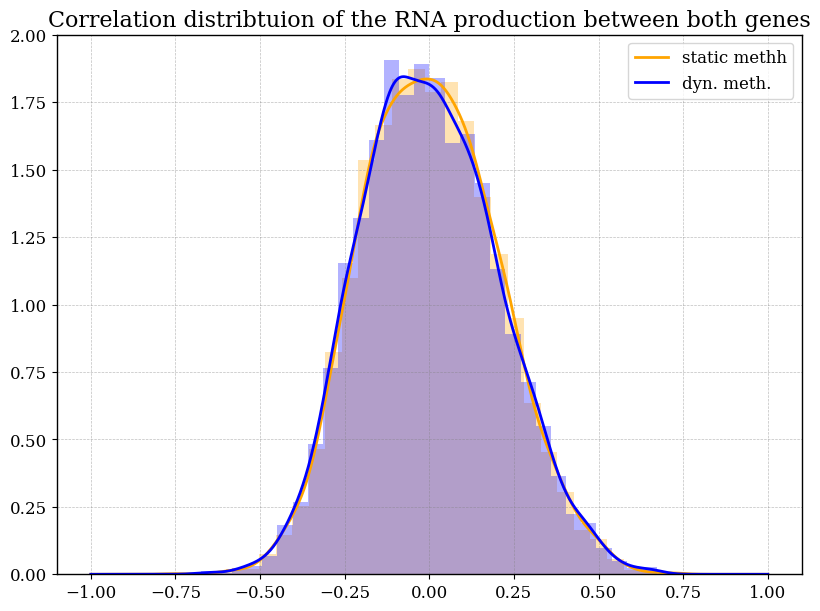

In [37]:
corrm1 = [i for i in corrm if ~np.isnan(i)]

corr1 = [i for i in corr if ~np.isnan(i)]

kde = stats.gaussian_kde(corr1)

kde_m = stats.gaussian_kde(corrm1)

xx = np.linspace(-1,1, 1000)
fig, ax = plt.subplots(figsize=(8,6))

ax.hist(corr1, density=True, bins=30, alpha=0.3, color="orange")
ax.hist(corrm1, density=True, bins=30, alpha=0.3, color="blue")
ax.plot(xx, kde(xx), label="static methh", color="orange")
ax.plot(xx, kde_m(xx), label="dyn. meth.", color="blue")
plt.legend()
plt.title("Correlation distribtuion of the RNA production between both genes")
#plt.savefig("figures/corr1.png", dpi=300)
plt.show()

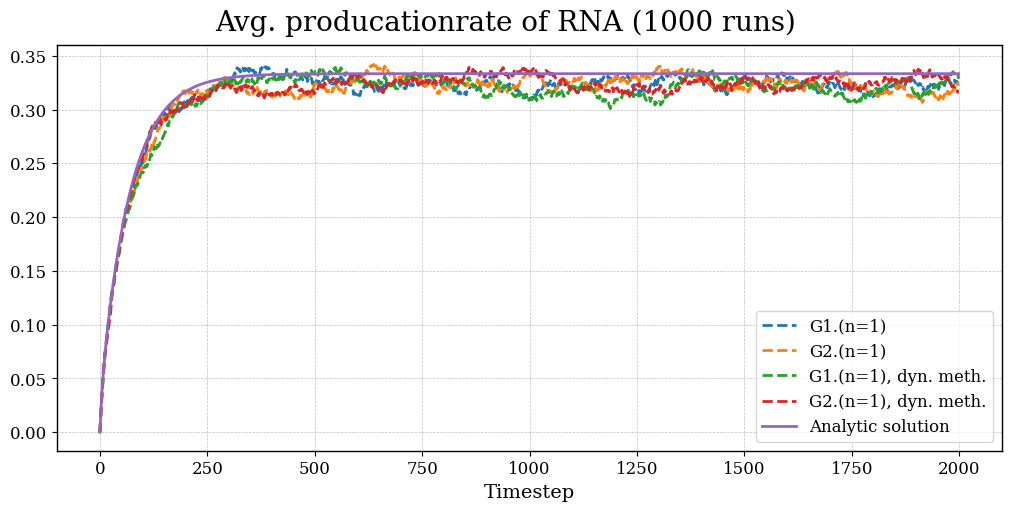

In [38]:
def analytic(length: int, p_on:float, p_off: float, timesteps: int):
    x = [i for i in range(timesteps)]
    y = []
    for i in x:
        solution = length*(p_on/(p_on+p_off))*(1-np.exp(-(p_off+p_on)*i))
        y.append(solution)

    return x,y

def analytic_meth(length: int, p_on:float, p_off: float, m_on: float, m_off: float, timesteps: int):        #constant methylation rate!
    x = [i for i in range(timesteps)]
    y = []
    k, m = p_on+p_off, m_on+m_off

    a = p_on*(m-m_on)
    b = -k*m + m_on*p_on
    c = m + k
    g_1, g_2 = (-c+np.sqrt(c**2+4*b))/2, (-c-np.sqrt(c**2+4*b))/2
    c_1 = ((g_2*a - p_on*b)/(b*(g_2-g_1)))
    for i in x:
        theta = c_1*np.exp(g_1*i) + (a/b - c_1)*np.exp(g_2*i) - a/b
        solution = length*theta
        y.append(solution)
    return x,y

time = simu.timeline

x,y = analytic_meth(n, p_on=p1, p_off=p1, m_on=m_on, m_off=m_off, timesteps = steps)

fig, ax1 = plt.subplots(figsize=(10,5))

ax1.plot(time, avg1, label="G1.(n={})".format(n), linestyle="--")
ax1.plot(time, avg2, label="G2.(n={})".format(n), linestyle="--")

ax1.plot(time, avg1m, label="G1.(n={}), dyn. meth.".format(n), linestyle="--")
ax1.plot(time, avg2m, label="G2.(n={}), dyn. meth.".format(n), linestyle="--")

ax1.plot(x,y, label="Analytic solution")

ax1.set_xlabel("Timestep")
# ax1.set_title("Avg. producationrate of protein (1000 shots)")
# ax2.set_title("Avg. producationrate of protein (1000 shots)")
plt.suptitle("Avg. producationrate of RNA (1000 runs)", fontsize=20)
plt.legend()
#plt.savefig("figures/rna1.png", dpi = 300)
plt.show()

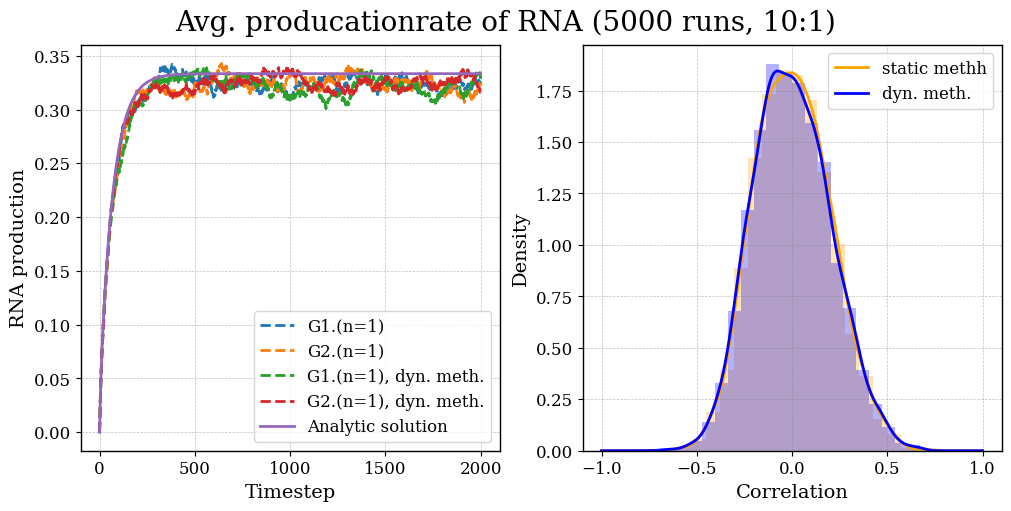

In [39]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.plot(time, avg1, label="G1.(n={})".format(n), linestyle="--")
ax1.plot(time, avg2, label="G2.(n={})".format(n), linestyle="--")

ax1.plot(time, avg1m, label="G1.(n={}), dyn. meth.".format(n), linestyle="--")
ax1.plot(time, avg2m, label="G2.(n={}), dyn. meth.".format(n), linestyle="--")

ax1.plot(x,y, label="Analytic solution")

ax1.set_xlabel("Timestep")
ax1.set_ylabel("RNA production")

ax1.legend()

ax2.hist(corr1, density=True, bins=20, alpha=0.3, color="orange")
ax2.hist(corrm1, density=True, bins=20, alpha=0.3, color="blue")
ax2.plot(xx, kde(xx), label="static methh", color="orange")
ax2.plot(xx, kde_m(xx), label="dyn. meth.", color="blue")
ax2.set_xlabel("Correlation")
ax2.set_ylabel("Density")
ax2.legend()

# ax1.set_title("Avg. producationrate of protein (1000 shots)")
# ax2.set_title("Avg. producationrate of protein (1000 shots)")
plt.suptitle("Avg. producationrate of RNA ({} runs, 10:1)".format(shots), fontsize=20)
plt.savefig("figures/corr3.png", dpi = 300)
plt.show()

In [ ]:
n = 50

p1, m_on, m_off = 0.2, 0.05, 0.05

simu = simulation(timesteps=200)

avg1_n, std1_n, avg2_n, std2_n, corr_n = simu.average(n, p1, m_on, m_off, 1000, m_switch=False)
avg1m_n, std1m_n, avg2m_n, std2m_n, corrm_n = simu.average(n, p1, m_on, m_off, 1000, m_switch=True)

In [21]:
max_len = len(avg1_n)

def pad_list(lst, length):
    return lst + [0] * (length - len(lst))

corr_n_padded = pad_list(corr_n, max_len)
corrm_n_padded = pad_list(corrm_n, max_len)

cols = ["avg1", "std1", "avg2", "std2", "corr", 
        "avg1m", "std1m", "avg2m", "std2m", "corrm"]
header = "time\t" + "\t".join(f"{c}_{n}" for c in cols)

data_n = np.column_stack((simu.timeline, avg1_n, std1_n, avg2_n, std2_n, corr_n_padded
                          , avg1m_n, std1m_n, avg2m_n, std2m_n, corrm_n_padded ))

np.savetxt("data/length{}.txt".format(n), data_n, fmt="%f", header=header, delimiter="\t")

In [5]:
data = np.loadtxt("data/length10.txt", delimiter="\t", skiprows=1)

time       = data[:, 0]
avg1_10    = data[:, 1]
std1_10    = data[:, 2]
avg2_10    = data[:, 3]
std2_10    = data[:, 4]
corr_10 = data[:100, 5]

avg1m_10    = data[:, 6]
std1m_10    = data[:, 7]
avg2m_10    = data[:, 8]
std2m_10    = data[:, 9]
corrm_10 = data[:100, 10]


data = np.loadtxt("data/length30.txt", delimiter="\t", skiprows=1)

time       = data[:, 0]
avg1_30    = data[:, 1]
std1_30    = data[:, 2]
avg2_30    = data[:, 3]
std2_30    = data[:, 4]
corr_30 = data[:100, 5]

avg1m_30    = data[:, 6]
std1m_30    = data[:, 7]
avg2m_30    = data[:, 8]
std2m_30    = data[:, 9]
corrm_30 = data[:100, 10]


data = np.loadtxt("data/length50.txt", delimiter="\t", skiprows=1)

time       = data[:, 0]
avg1_50    = data[:, 1]
std1_50    = data[:, 2]
avg2_50    = data[:, 3]
std2_50    = data[:, 4]
corr_50 = data[:100, 5]

avg1m_50    = data[:, 6]
std1m_50    = data[:, 7]
avg2m_50    = data[:, 8]
std2m_50    = data[:, 9]
corrm_50 = data[:100, 10]

# data = np.loadtxt("data/length100_corr.txt", delimiter="\t", skiprows=1)

# time       = data[:, 0]
# avg1_100    = data[:, 1]
# std1_100   = data[:, 2]
# avg2_100    = data[:, 3]
# std2_100    = data[:, 4]
# corr_100 = data[:100, 5]

# avg1m_100    = data[:, 6]
# std1m_100   = data[:, 7]
# avg2m_100   = data[:, 8]
# std2m_100    = data[:, 9]
# corrm_100 = data[:100, 10]

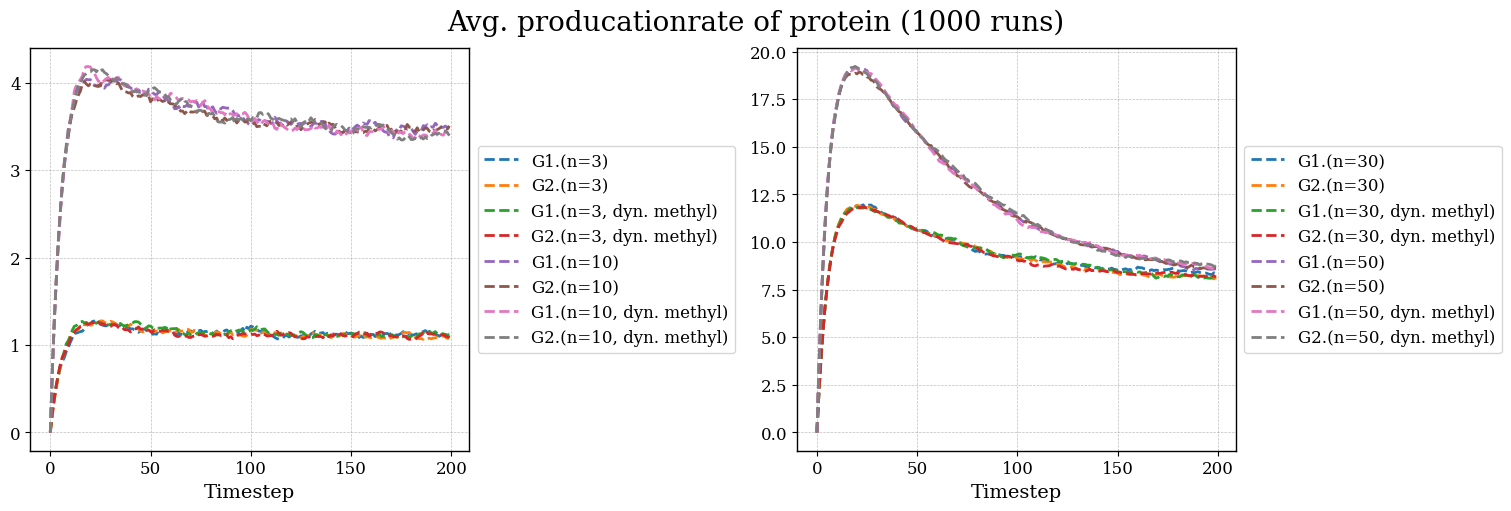

For 3 lattice sites:

Avg. Correlation bewteen the protein prodcution of each gene:  0.08535089536426471
Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour):  0.04476683423206664

 For 10 lattice sites:

Avg. Correlation bewteen the protein prodcution of each gene:  0.08718350000000001
Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour):  0.10124534

 For 30 lattice sites:

Avg. Correlation bewteen the protein prodcution of each gene:  0.26387796999999996
Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour):  0.27688848000000005

 For 50 lattice sites:

Avg. Correlation bewteen the protein prodcution of each gene:  0.57338773
Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour):  0.56790551


In [6]:
time = simu.timeline

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))


ax1.plot(time, avg1, label="G1.(n=3)", linestyle="--")
ax1.plot(time, avg2, label="G2.(n=3)", linestyle="--")

ax1.plot(time, avg1m, label="G1.(n=3, dyn. methyl)", linestyle="--")
ax1.plot(time, avg2m, label="G2.(n=3, dyn. methyl)", linestyle="--")

ax1.plot(time, avg1_10, label="G1.(n=10)", linestyle="--")
ax1.plot(time, avg2_10, label="G2.(n=10)", linestyle="--")

ax1.plot(time, avg1m_10, label="G1.(n=10, dyn. methyl)", linestyle="--")
ax1.plot(time, avg2m_10, label="G2.(n=10, dyn. methyl)", linestyle="--")

ax2.plot(time, avg1_30, label="G1.(n=30)", linestyle="--")
ax2.plot(time, avg2_30, label="G2.(n=30)", linestyle="--")

ax2.plot(time, avg1m_30, label="G1.(n=30, dyn. methyl)", linestyle="--")
ax2.plot(time, avg2m_30, label="G2.(n=30, dyn. methyl)", linestyle="--")

ax2.plot(time, avg1_50, label="G1.(n=50)", linestyle="--")
ax2.plot(time, avg2_50, label="G2.(n=50)", linestyle="--")

ax2.plot(time, avg1m_50, label="G1.(n=50, dyn. methyl)", linestyle="--")
ax2.plot(time, avg2m_50, label="G2.(n=50, dyn. methyl)", linestyle="--")

# ax2.plot(time, avg1_100, label="G1.(n=100)", linestyle="--")
# ax2.plot(time, avg2_100, label="G2.(n=100)", linestyle="--")

# ax2.plot(time, avg1m_100, label="G1.(n=100, dyn. methyl)", linestyle="--")
# ax2.plot(time, avg2m_100, label="G2.(n=100, dyn. methyl)", linestyle="--")

ax1.set_xlabel("Timestep")
ax2.set_xlabel("Timestep")
# ax1.set_title("Avg. producationrate of protein (1000 shots)")
# ax2.set_title("Avg. producationrate of protein (1000 shots)")
plt.suptitle("Avg. producationrate of protein (1000 runs)", fontsize=20)
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("figures/plot1.pdf")
plt.show()

print("For 3 lattice sites:\n")
print("Avg. Correlation bewteen the protein prodcution of each gene: ", np.mean(corr))
print("Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour): ",  np.mean(corrm))

print("\n For 10 lattice sites:\n")
print("Avg. Correlation bewteen the protein prodcution of each gene: ",  np.mean(corr_10))
print("Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour): ",  np.mean(corrm_10))

print("\n For 30 lattice sites:\n")
print("Avg. Correlation bewteen the protein prodcution of each gene: ",  np.mean(corr_30))
print("Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour): ",  np.mean(corrm_30))

print("\n For 50 lattice sites:\n")
print("Avg. Correlation bewteen the protein prodcution of each gene: ",  np.mean(corr_50))
print("Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour): ",  np.mean(corrm_50))

# print("\n For 100 lattice sites:\n")
# print("Avg. Correlation bewteen the protein prodcution of each gene: ", corr_100)
# print("Avg. Correlation bewteen the protein prodcution of each gene (with dyn. methlyzation being affected by neighbour): ", corrm_100)

MEthylazsation based on avergae methylzation   --> Check

Off methylazation is constant       --> Check

Check analytic solution and compare for one box first  --> Check (no methylation)

Off box prob is likely a bit higher than one (can ignore for now)

dont take average of corr, plot histrogramm of all the runs, look at variance     --> Check

In the limit where the rate for on/off is similar to timescale, we should see pseudo correlation

Also tweak the mehtylataion rate in a regime, where one gene might become fully methylated --> possible high correlation!